In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import Lasso

In [3]:
#objective with the barrier log
def obj(Q,p,A,t,v):
  return t*(v.T @ Q @ v +v.T @p) - np.sum(np.log(b - A @ v))
  
def grad(Q,p,A_tilde,t,v):
  return t*(2*Q @v + p) + A_tilde.T @ np.ones(A.shape[0])

def hess(Q,p,A_tilde,t,v):
  return 2*t*Q  + A_tilde.T @ A_tilde

In [4]:
def centering_step(Q,p,A,b,t,v0,eps,alpha=0.5,beta=0.9):

  #saving v_i (evolution of v along iterations)in a list v_record
  v_record=[v0]

  v = v0
  test = True

  while test: 
    #compute gradient and hessien of t*f(v)+phi(v)
    A_tilde = A.copy()
    for i in range(A.shape[0]):
      A_tilde[i,:] = A[i,:]/(b[i]-A[i,:].T@v)
    gradient = grad(Q,p,A_tilde,t,v)
    hessien = hess(Q,p,A_tilde,t,v)

    #newton step
    delta_v = np.linalg.solve(hessien,-gradient)

    #newton decrement 
    lambda_v = - gradient.T @ delta_v

    #stopping criterion
    test = 0.5*lambda_v < eps

    #backtracking line search
    h = 1
    while (np.all(A@(v+h*delta_v) <= b)) and (obj(Q,p,A,t,v+h*delta_v) < obj(Q,p,A,t,v)-alpha*h*lambda_v):
      h = beta*h
    
    #update 
    v = v + h*delta_v

    v_record.append(v)

  return v_record
    

In [5]:
def barr_method(Q,p,A,b,v0,mu,eps,alpha=0.5,beta =0.9):
  # initialization
  v_seq = [v0]
  t = 1
  m = len(b)

  while m/t > eps:
      v = centering_step(Q, p, A, b, t, v_seq[-1], eps=eps, alpha=alpha, beta=beta)[-1]
      v_seq.append(v)
      t *= mu

  return v_seq

In [6]:
def dual_parameters(X,y,lambd):
  n ,d = X.shape
  Q = np.eye(n) / 2
  p = - y
  A = np.concatenate((X.T, - X.T), axis=0)
  b = lambd * np.ones(2 * d)
  return Q, p, A, b

In [7]:
#question 3 : generate random X and y
n, d, lambd = 20, 50, 10
X =  np.random.randn(n, d)
y = np.ones(n) + 2 * np.random.randn(n)

#define the dual problem 's parameters
Q, p, A, b = dual_parameters(X,y,lambd)

#feasible start point 
v0=np.zeros(n)


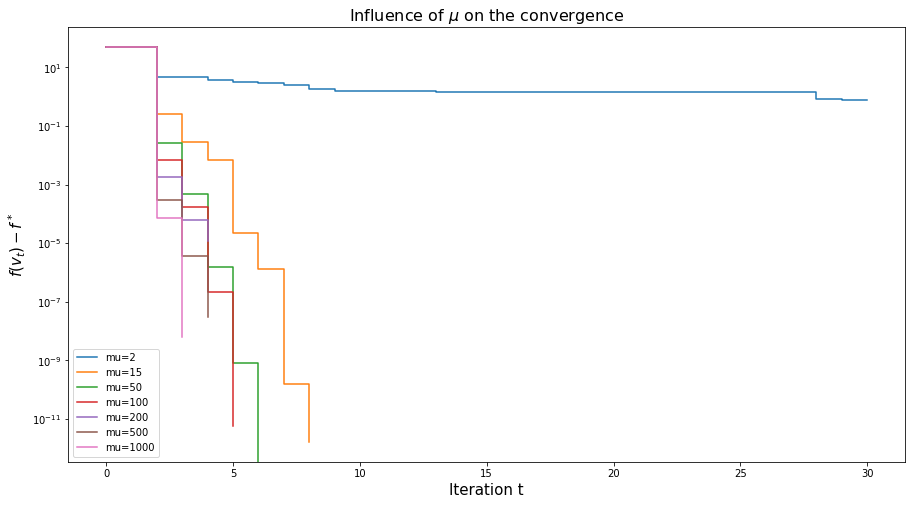

In [11]:
mu_values = [2, 15, 50, 100, 200,500,1000]
results = [barr_method(Q,p,A,b,v0,mu,eps=1e-7,alpha=0.25,beta =0.9) for mu in mu_values]
f_values = [[v.T @ Q @ v + p.T @ v for v in results[i]] for i in range(len(results))]
f_star = np.infty
for i in range(len(results)):
    for f in f_values[i]:
        if f_star > f:
            f_star = f

plt.figure(figsize=(15,8))
plt.xlabel('Iteration t',fontsize = 15)
plt.ylabel('$f(v_t) - f^*$',fontsize=15)
plt.yscale("log")
plt.title('Influence of $\\mu$ on the convergence',fontsize=16)
for i in range(len(results)):
    plt.step(np.arange(len(results[i])),f_values[i] - f_star,where="post",label='mu={}'.format(mu_values[i]))
plt.legend(loc="best")
plt.show()

Text(0, 0.5, 'Required iterations to converge')

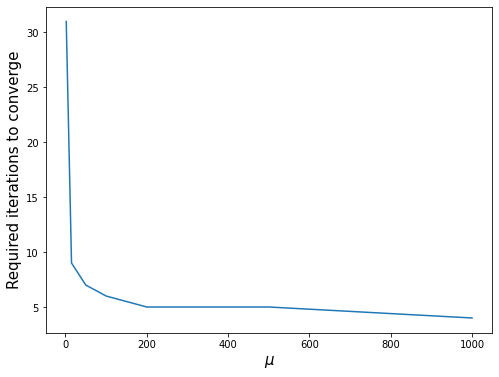

In [9]:
plt.figure(figsize=(8,6))
nb_iterations= [len(x) for x in results]
plt.plot(mu_values,nb_iterations)
plt.xlabel('$\\mu$',fontsize = 15)
plt.ylabel('Required iterations to converge',fontsize=15)



Text(0.5, 1.0, 'Impact of $\\mu$ on $\\||w^*||_1$')

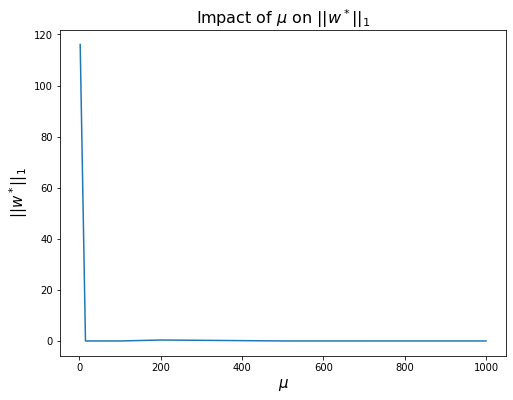

In [28]:
v_stars = []
for i in range(len(results)):
  f_star_mu = np.inf
  index=0
  for k in range(len(f_values[i])):
      if f_star_mu > f:
            f_star_mu = f_values[i][k]
            index=k
  v_stars.append(results[i][k])

w_stars = [np.linalg.solve(X.T@X,X.T@(y-v)) for v in v_stars]
l1_w_stars = [np.linalg.norm(w,ord=1) for w in w_stars]

plt.figure(figsize=(8,6))
plt.plot(mu_values, l1_w_stars )
plt.xlabel('$\\mu$',fontsize = 15)
plt.ylabel('$\\||w^*||_1$',fontsize=15)
plt.title('Impact of $\\mu$ on $\\||w^*||_1$',fontsize=16)


Text(0.5, 1.0, 'Impact of $\\mu$ on $\\||w^*||_1$')

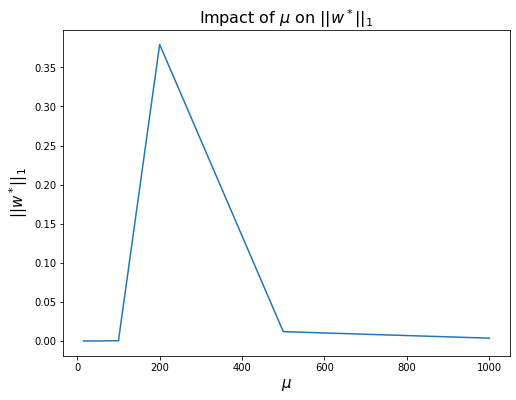

In [29]:
#removing mu =2
plt.figure(figsize=(8,6))
plt.plot(mu_values[1:], l1_w_stars[1:] )
plt.xlabel('$\\mu$',fontsize = 15)
plt.ylabel('$\\||w^*||_1$',fontsize=15)
plt.title('Impact of $\\mu$ on $\\||w^*||_1$',fontsize=16)
